In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
root_path = '/workdir/radish/PET-CT/splited_3D_CT_PET_V2/train'


In [7]:
CHUNK_LENGTH = 2
STEP = 1
def save(save_dir, root_path, max_records = 6000): 
    input_dir = save_dir + '/A'
    output_dir = save_dir + '/B'
    os.makedirs(input_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)
    index = 0 
    num_patients = 0
    for folder in os.listdir(root_path):
        a = np.load(root_path + folder + '/ct.npy', allow_pickle=True)
        b = np.load(root_path + folder + '/pet.npy', allow_pickle=True)
        if (a.shape[0] != b.shape[0]):
            print(folder)
            print(a.shape)
            print(b.shape)
            print('----------------------')
            continue
        num_patients = num_patients + 1
        for i in tqdm(range(0, a.shape[0]- CHUNK_LENGTH, STEP)):
            inp = a[i+1:i+CHUNK_LENGTH]
            out = b[i:i+CHUNK_LENGTH] 
            np.save(f'{input_dir}/{index}.npy', inp)
            np.save(f'{output_dir}/{index}.npy', out)
            index = index + 1 
            if (index >= max_records):
                return (index, num_patients)

In [8]:
root_path = '/workdir/radish/PET-CT/splited_3D_CT_PET_V2/train/'
save_dir = '2D_consistance/train'
index, num =  save(save_dir, root_path, max_records = 30000)
print(f'Number of patients: {num}')

 99%|█████████▉| 270/273 [00:00<00:00, 1914.71it/s]

Number of patients: 108


In [9]:
root_path = '/workdir/radish/PET-CT/splited_3D_CT_PET_V2/val/'
save_dir = '2D_consistance/val'
index, num =  save(save_dir, root_path, max_records = 1000)
print(f'Number of patients: {num}')

 16%|█▌        | 52/333 [00:00<00:00, 1721.96it/s]

Number of patients: 4


In [14]:
a = np.load( '/home/PET-CT/huutien/Reg-GAN/2D_consistance/train/B/29991.npy', allow_pickle=True)
a.shape

(2, 256, 256)

In [21]:
import torch.nn as nn
import torch
loss = nn.MSELoss()
input = torch.randn(30,2, 256, 256, requires_grad=True)
target = torch.randn(30, 2, 256, 256)
output = loss(input, target)
output.backward()

In [22]:
output

tensor(2.0000, grad_fn=<MseLossBackward0>)

In [4]:
import torch 
real_A = torch.randn(30, 2, 256, 256)
a = real_A[:, 1, :, :].unsqueeze(1)
a.shape

/root/anaconda3/envs/BBDM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([30, 1, 256, 256])

In [1]:
import numpy as np
gt = np.load('/workdir/radish/PET-CT/data_gen/3D_LABELED_CT_PET_V2/1.2.840.113619.2.290.3.663120.224.1715908786.145/pet.npy')
a = np.load('/workdir/radish/PET-CT/3D_reggan/metric/1.2.840.113619.2.290.3.663120.224.1715908786.145/predicted_volume_registered.npy', allow_pickle=True)  

((247, 256, 256), (247, 256, 256))

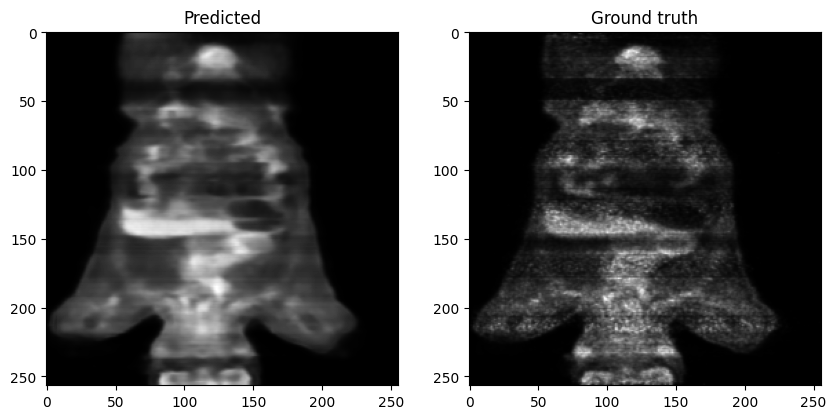

In [2]:
# visualize a and gt in a figure
import matplotlib.pyplot as plt
import numpy as np

index = 120


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(a[:, index], cmap='gray')
axs[0].set_title('Predicted')
axs[1].imshow(gt[:, index], cmap='gray')
axs[1].set_title('Ground truth')
plt.show()

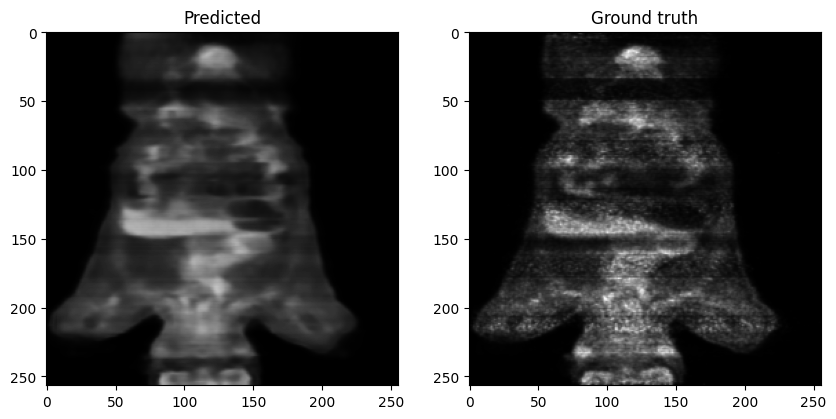

In [37]:
import numpy as np
patient_id = '1.2.840.113619.2.55.3.663376.78.1704246114.421'
gt = np.load(f'/workdir/radish/PET-CT/data_gen/3D_LABELED_CT_PET_V2/{patient_id}/pet.npy')
a = np.load(f'/workdir/radish/PET-CT/3D_reggan/metric/{patient_id}/3D_model_overlap_5.npy', allow_pickle=True)  
index = 120


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(a[:, index], cmap='gray', vmin=0, vmax=32767)
axs[0].set_title('Predicted')
axs[1].imshow(gt[:, index], cmap='gray', vmin=0, vmax=32767)
axs[1].set_title('Ground truth')
plt.show()

In [39]:
import cv2
import numpy as np

# Input voxel data (example: 300 depth slices, 256x256 each)
voxel_data = a # Replace with actual data
voxel_data = voxel_data
# Placeholder for smoothed voxel data
smoothed_voxel_data = np.copy(voxel_data)

# Loop through depth slices
for i in range(voxel_data.shape[0] - 1):
    slice1 = voxel_data[i]
    slice2 = voxel_data[i + 1]
    
    # Normalize slices to [0, 255] for optical flow calculation
    slice1 = cv2.normalize(slice1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    slice2 = cv2.normalize(slice2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Calculate optical flow (Farneback method)
    flow = cv2.calcOpticalFlowFarneback(slice1, slice2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Interpolate intermediate slice
    h, w = slice1.shape
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (grid_x + flow[..., 0]).astype(np.float32)
    map_y = (grid_y + flow[..., 1]).astype(np.float32)
    
    # Warp slice1 towards slice2
    interpolated_slice = cv2.remap(slice1, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    
    # Blend the interpolated slice into the smoothed data
    smoothed_voxel_data[i] = 0.5 * voxel_data[i] + 0.5 * interpolated_slice

# The resulting `smoothed_voxel_data` has smooth transitions in the depth dimension.

In [40]:
voxel_data.max(), voxel_data.min()

(28101.393, 0.0)

In [41]:
smoothed_voxel_data.max(), smoothed_voxel_data.min()

(24075.867, 0.0)

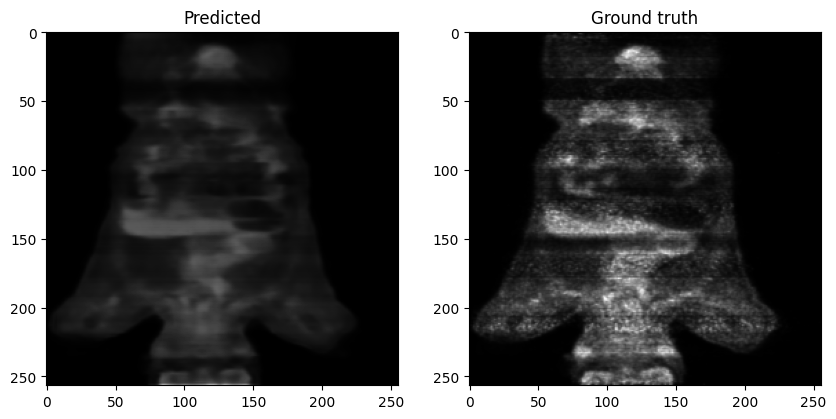

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(smoothed_voxel_data[:, index], cmap='gray', vmin=0, vmax=32767)
axs[0].set_title('Predicted')
axs[1].imshow(gt[:, index], cmap='gray', vmin=0, vmax=32767)
axs[1].set_title('Ground truth')
plt.show()

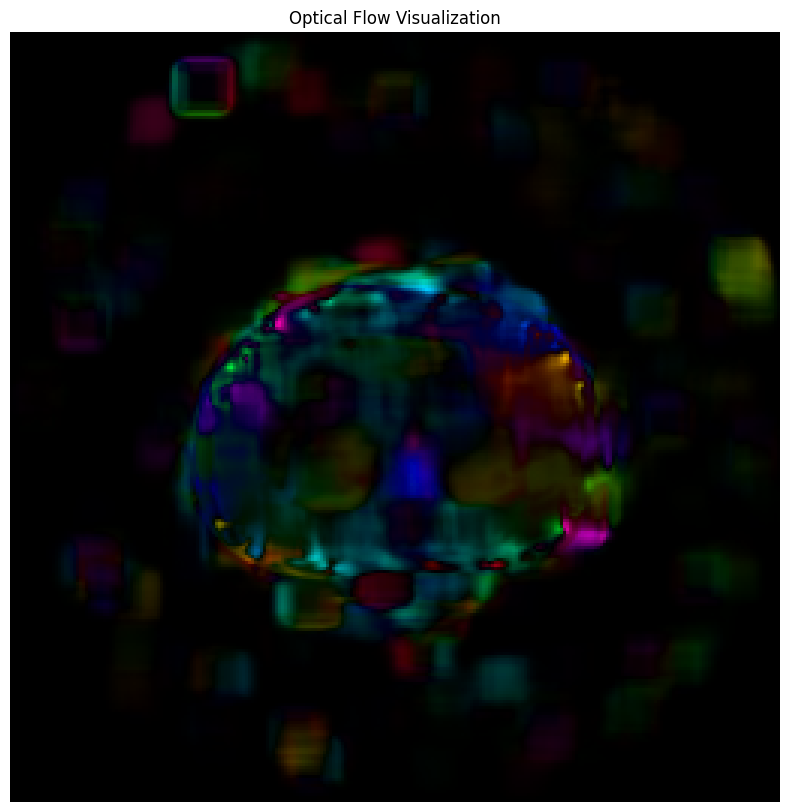

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Extract two consecutive slices
slice1 = gt[100]  # Example: first slice
slice2 = gt[101]  # Example: second slice

# Ensure the slices are converted to float32
slice1 = slice1.astype(np.float32)
slice2 = slice2.astype(np.float32)

# Compute optical flow
flow = cv2.calcOpticalFlowFarneback(slice1, slice2, None, 
                                    pyr_scale=0.5, levels=3, winsize=15, 
                                    iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

# Convert flow to HSV for visualization
magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
hsv = np.zeros((slice1.shape[0], slice1.shape[1], 3), dtype=np.uint8)
hsv[..., 0] = np.uint8(180 * angle / np.pi / 2)  # Hue represents direction
hsv[..., 1] = 255  # Saturation
hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)  # Value represents magnitude

# Convert HSV to RGB for display
rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# Visualize
plt.figure(figsize=(10, 10))
plt.imshow(rgb_flow)
plt.title('Optical Flow Visualization')
plt.axis('off')
plt.show()

In [11]:
flow

array([[[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        ...,
        [ 9.61305792e-35, -1.55531190e-35],
        [ 9.61305792e-35, -1.55531190e-35],
        [ 9.61305792e-35, -1.55531190e-35]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        ...,
        [ 3.78002433e-34, -1.03076335e-33],
        [ 3.78002433e-34, -1.03076335e-33],
        [ 3.78002433e-34, -1.03076335e-33]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        ...,
        [ 5.66644591e-33,  6.97726519e-34],
        [ 5.66644591e-33,  6.97726519e-34],
        [ 5.66644591e-33,  6.97726519e-34]],

       ...,

       [[ 3.56955690e-18, -3.86113600e-18],
        [ 6.16516787e-19, -9.82402192e-19],
        [ 3.25734859e-19,  1.88321522e-18],
        ...,
     

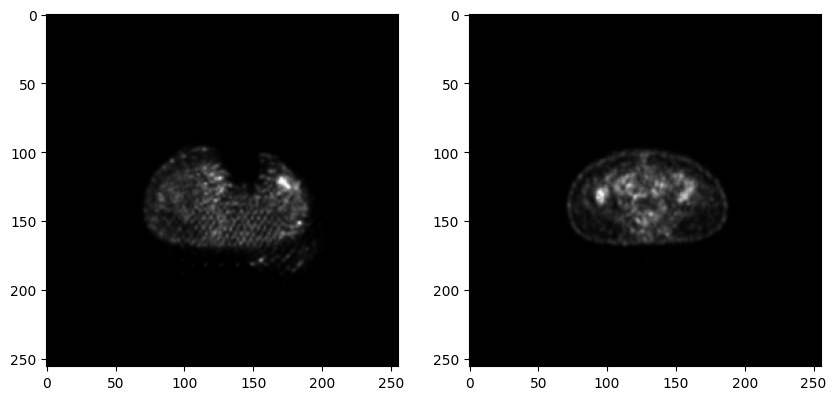

In [8]:
import matplotlib.pyplot as plt
index = 80
# plot a and gt in a plot 
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(a[index], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(gt[index], cmap='gray')
plt.show()
